In [149]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [150]:
df = pd.read_csv('iris - iris.csv')

In [151]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [153]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [154]:
df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [155]:
X = df.drop('species', axis=1)
y = df['species']

In [156]:
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [157]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Convert string labels to numerical labels using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)  # Fit and transform on training data
y_test = le.transform(y_test)       # Transform test data using the fitted encoder

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [159]:
# Define the neural network model
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 3) # 3 output classes for multiclass

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # no activation here because CrossEntropyLoss includes softmax
        return x

In [160]:
# Initialize the model, loss function, and optimizer
model = IrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [161]:
# Early stopping parameters
patience = 4  # Number of epochs to wait for improvement
min_delta = 0.0001  # Minimum change in validation loss to qualify as an improvement
best_val_loss = float('inf')
patience_counter = 0

# Training loop
num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()

    # Forward pass (training)
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_losses.append(loss.item())

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation (every 10 epochs)
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)
            val_losses.append(val_loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

# Load the best model after training
model.load_state_dict(torch.load('best_model.pth'))

Epoch [10/1000], Train Loss: 1.0701, Val Loss: 1.0684
Epoch [20/1000], Train Loss: 1.0174, Val Loss: 1.0113
Epoch [30/1000], Train Loss: 0.9282, Val Loss: 0.9134
Epoch [40/1000], Train Loss: 0.8061, Val Loss: 0.7821
Epoch [50/1000], Train Loss: 0.6639, Val Loss: 0.6320
Epoch [60/1000], Train Loss: 0.5368, Val Loss: 0.4993
Epoch [70/1000], Train Loss: 0.4489, Val Loss: 0.4097
Epoch [80/1000], Train Loss: 0.3851, Val Loss: 0.3450
Epoch [90/1000], Train Loss: 0.3299, Val Loss: 0.2858
Epoch [100/1000], Train Loss: 0.2784, Val Loss: 0.2315
Epoch [110/1000], Train Loss: 0.2302, Val Loss: 0.1839
Epoch [120/1000], Train Loss: 0.1856, Val Loss: 0.1443
Epoch [130/1000], Train Loss: 0.1481, Val Loss: 0.1141
Epoch [140/1000], Train Loss: 0.1190, Val Loss: 0.0910
Epoch [150/1000], Train Loss: 0.0980, Val Loss: 0.0735
Epoch [160/1000], Train Loss: 0.0831, Val Loss: 0.0601
Epoch [170/1000], Train Loss: 0.0724, Val Loss: 0.0501
Epoch [180/1000], Train Loss: 0.0646, Val Loss: 0.0427
Epoch [190/1000], T

C:\Users\Dell\AppData\Local\Temp\ipykernel_15416\969155656.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

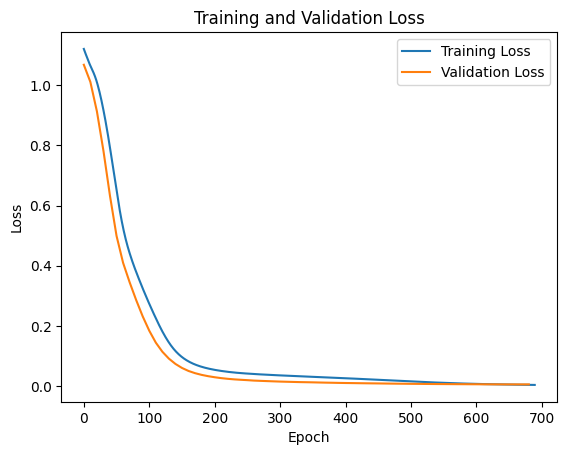

In [162]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
# Adjust x-axis data for validation loss to match the actual number of validation loss values
plt.plot(range(0, len(train_losses), int(len(train_losses) / len(val_losses))), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
ROC-AUC (One-vs-Rest): 1.00


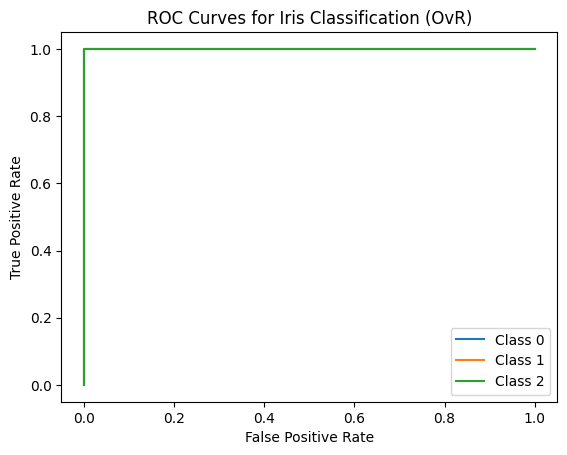

In [163]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    _, y_pred_classes = torch.max(y_pred, 1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy*100:.2f}%")

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Calculate ROC AUC for each class (One-vs-Rest)
y_test_np = y_test.numpy()
y_pred_np = torch.softmax(y_pred, dim=1).numpy()

roc_auc_ovr = roc_auc_score(y_test_np, y_pred_np, multi_class='ovr')
print(f"ROC-AUC (One-vs-Rest): {roc_auc_ovr:.2f}")

# ROC curve for each class
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_np == i, y_pred_np[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Iris Classification (OvR)")
plt.legend()
plt.show()